We apply the 3 Voronoi tests we developed to use on 34 samples grown in natural environment and access performance of hydathode and veins, compared to the 3 pointsets.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statannot import add_stat_annotation
from matplotlib.collections import LineCollection

# bayesian inference modules
import bambi as bmb 
import arviz as az

import sys
sys.path.insert(0, '../')
import graph_create

-------

### Step 0: read in the recently traced graphs

In [8]:
dot_folder = f'../data/natural/natural_dots_all'
vein_folder = f'../data/natural/natural_txt_all'
samples = pd.read_csv('../data/natural/natural_all.csv', delimiter=',', header = None)

In [9]:
sample_list = samples[0].tolist()

In [10]:
def shape_dfs(data_arr, value_name = 'error'):
    
    mean_df = pd.DataFrame(data_arr, index = sample_list, columns = ['hydathode','centroid','mid-point','random'])
    mean_df['plant'] = samples[1].tolist()
    mean_df['sample'] = mean_df.index

    melted_mean_df = mean_df.melt(id_vars= ['sample', 'plant'] , var_name='type', value_name= value_name)
    melted_mean_df["type"]  = pd.Categorical(melted_mean_df["type"].tolist(), categories = ['hydathode','centroid','mid-point','random'], ordered=True)

    return mean_df, melted_mean_df

-------

### Step 1: local tests (Voronoi I):

In [11]:
import voronoi_local

In [12]:
angle_mean_arr = np.zeros([34,4])
dist_mean_arr = np.zeros([34,4])

In [13]:
def local_error(sample):
    G = graph_create.graph_creation(sample, dot_folder= dot_folder, vein_folder = vein_folder)

    print('Perform local tests... \n')
    # local tests:
    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)

    # baseline local tests:
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)    
    centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
    midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
    random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

    G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])

    baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

    angle_list = [baseline_summary['angle_mean'][0],
                        baseline_summary['angle_mean'][1],
                        baseline_summary['angle_mean'][2],
                        baseline_summary['angle_mean'][3]]

    dist_list = [baseline_summary['dist_mean'][0],
                        baseline_summary['dist_mean'][1],
                        baseline_summary['dist_mean'][2],
                        baseline_summary['dist_mean'][3]]

    print('Local tests done! \n')

    return angle_list, dist_list, rst[1].shape[0], len(G.graph['dots_passed'])


In [14]:
for i, sample in enumerate(sample_list):
    angle_list, dist_list, num_pair, num_face = local_error(sample)
    angle_mean_arr[i] = angle_list
    dist_mean_arr[i] = dist_list

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Grap

../voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])
../voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Perform local tests... 

Local tests done! 

Creating graph from vein and dot tracin

In [11]:
angle_mean_df, melted_angle_mean_df = shape_dfs(angle_mean_arr, value_name = 'error')

#### Bayesian Linear Mixed Effects Models

Since many leaf samples we use comes from the same plants, we introduce plant as a variable in potentially explaining the variations in the Voronoi test performance. Therefore, we choose to use Bayesian Linear Mixed Effects Models to distangle the random effects (called `Group-level effects` in the model description) of plants from the performance difference given the type of point set we use.

In [13]:
# setting up model
angle_model= bmb.Model("error ~ type + (1|plant)", melted_angle_mean_df, dropna=True, categorical = "type")
angle_model

Formula: error ~ type + (1|plant)
Family name: Gaussian
Link: identity
Observations: 136
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 11.9536, sigma: 17.0725)
    type ~ Normal(mu: [0. 0. 0.], sigma: [27.8793 27.8793 27.8793])

  Group-level effects
    1|plant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 17.0725))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 4.8288)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
angle_results =angle_model.fit(chains=5, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, type, 1|plant_sigma, 1|plant_offset, error_sigma]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 402 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6798, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
angle_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
az.summary(angle_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.255,0.522,7.299,9.248,0.012,0.008,2476.0,1837.0,1.0
type[centroid],1.110,0.423,0.377,1.960,0.006,0.004,5243.0,4672.0,1.0
type[mid-point],2.416,0.429,1.621,3.239,0.006,0.004,5093.0,4069.0,1.0
type[random],11.338,0.428,10.521,12.124,0.006,0.004,5078.0,3599.0,1.0
1|plant_sigma,0.935,0.453,0.269,1.815,0.010,0.007,2258.0,2271.0,1.0
error_sigma,1.724,0.110,1.514,1.921,0.001,0.001,6026.0,5359.0,1.0
1|plant[1],0.478,0.510,-0.441,1.511,0.010,0.007,2762.0,2190.0,1.0
1|plant[2],0.921,0.543,-0.030,1.989,0.011,0.008,2755.0,2274.0,1.0
1|plant[3],-0.506,0.527,-1.542,0.444,0.010,0.009,2963.0,2249.0,1.0
1|plant[4],-0.494,0.527,-1.538,0.445,0.011,0.010,2748.0,2053.0,1.0


#### Plot the inferred mean and 95% confidence interval:

In [16]:
slopes = angle_results.posterior.type.values
intercept = angle_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [17]:
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hydathode v.s. centroid: Custom statistical test, P_val:4.800e-03
hydathode v.s. mid-point: Custom statistical test, P_val:0.000e+00
hydathode v.s. random: Custom statistical test, P_val:0.000e+00


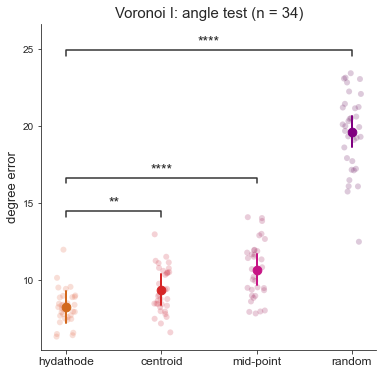

In [20]:
order = ['hydathode', 'centroid', 'mid-point', 'random']
colors = ['chocolate','tab:red', 'mediumvioletred', 'purple']
# colors = ['C1', 'C3', 'C6', 'C4']
sns.set_style("white")

fig, ax = plt.subplots(figsize = (6,6))

sns.stripplot (x = 'type', y = 'error', data = melted_angle_mean_df, order = order, 
               palette = "flare", alpha = .25, size = 6, zorder=1,
               ax = ax)

# adding annotations based on the p-direction values:
ax, test_results = add_stat_annotation(ax, data = melted_angle_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 14)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(angle_results)['mean']['Intercept'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[centroid]'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[mid-point]'],
           az.summary(angle_results)['mean']['Intercept'] + az.summary(angle_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 2)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 75, zorder = 2)

    
ax.set_title('Voronoi I: angle test (n = 34)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 12)
ax.set_xlabel(None)
ax.set_ylabel('degree error', fontsize = 13)
ax.set_yticks([10, 15, 20, 25], fontsize = 12)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

In [17]:
dist_mean_df, melted_dist_mean_df = shape_dfs(dist_mean_arr, value_name = 'error')

In [18]:
dist_mean_df.describe()

,hydathode,centroid,mid-point,random,plant
count,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.129425,0.213850,0.238199,0.411704,3.588235
std,0.023159,0.023278,0.028829,0.044703,1.777258
min,0.084133,0.172571,0.172421,0.327680,1.000000
25%,0.111114,0.196973,0.220108,0.387383,2.000000
50%,0.128462,0.208850,0.235508,0.408766,4.000000
75%,0.146049,0.226066,0.255491,0.445884,5.000000
max,0.171100,0.274341,0.317472,0.498002,6.000000


In [24]:
dist_model= bmb.Model("error ~ type + (1|plant)", melted_dist_mean_df, dropna=True, categorical = "type")
dist_results =dist_model.fit(chains=5, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, type, 1|plant_sigma, 1|plant_offset, error_sigma]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8791, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
dist_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [26]:
az.summary(dist_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.130,0.006,0.118,0.140,0.0,0.0,3208.0,2591.0,1.0
type[centroid],0.084,0.007,0.071,0.097,0.0,0.0,5786.0,6262.0,1.0
type[mid-point],0.109,0.007,0.095,0.122,0.0,0.0,5696.0,5575.0,1.0
type[random],0.283,0.007,0.270,0.296,0.0,0.0,6380.0,6468.0,1.0
1|plant_sigma,0.007,0.005,0.000,0.015,0.0,0.0,1856.0,1911.0,1.0
error_sigma,0.028,0.002,0.025,0.032,0.0,0.0,7054.0,5812.0,1.0
1|plant[1],0.002,0.005,-0.006,0.013,0.0,0.0,4521.0,3956.0,1.0
1|plant[2],0.003,0.005,-0.006,0.014,0.0,0.0,3793.0,2956.0,1.0
1|plant[3],0.000,0.005,-0.010,0.011,0.0,0.0,4158.0,3390.0,1.0
1|plant[4],0.002,0.005,-0.007,0.013,0.0,0.0,3898.0,3718.0,1.0


In [27]:
slopes = dist_results.posterior.type.values
intercept = dist_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [28]:
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hydathode v.s. centroid: Custom statistical test, P_val:0.000e+00
hydathode v.s. mid-point: Custom statistical test, P_val:0.000e+00
hydathode v.s. random: Custom statistical test, P_val:0.000e+00


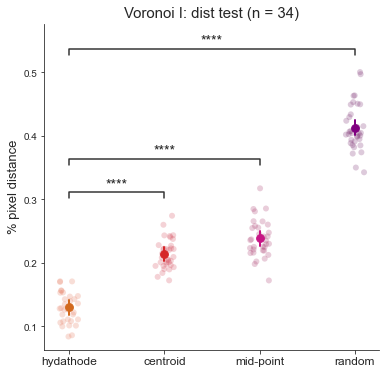

In [30]:
order = ['hydathode', 'centroid', 'mid-point', 'random']
colors = ['chocolate','tab:red', 'mediumvioletred', 'purple']
# colors = ['C1', 'C3', 'C6', 'C4']
sns.set_style("white")

fig, ax = plt.subplots(figsize = (6,6))

sns.stripplot (x = 'type', y = 'error', data = melted_dist_mean_df, order = order, 
               palette = "flare", alpha = .25, size = 6, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_dist_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 14)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(dist_results)['mean']['Intercept'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[centroid]'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[mid-point]'],
           az.summary(dist_results)['mean']['Intercept'] + az.summary(dist_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 2)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 60, zorder = 2)

    
ax.set_title('Voronoi I: dist test (n = 34)', fontsize = 15)

# ax.set_xlabel('point sets', fontsize = 12)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 12)
ax.set_xlabel(None)
ax.set_ylabel('% pixel distance', fontsize = 13)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()


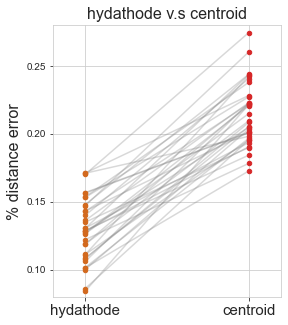

In [81]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (4.1,5))
ax.scatter(np.zeros(len(dist_mean_df)),dist_mean_df['hydathode'], 
            c = colors[0], zorder = 2, s = 20)
ax.scatter(np.ones(len(dist_mean_df)),dist_mean_df['centroid'], 
           c = colors[1], zorder = 2, s = 20)

# plotting the lines
for i in range(len(dist_mean_df)):
    ax.plot( [0, 1], [ dist_mean_df['hydathode'].loc[dist_mean_df.index[i]],  dist_mean_df['centroid'].loc[dist_mean_df.index[i]]], c='grey', alpha = .3,
             zorder = 1)

plt.xticks([0, 1], ['hydathode', 'centroid'],fontsize = 15)
plt.yticks([.1, .15, .2, .25])
plt.xlim([-.2, 1.2])
plt.ylim([.08, .28])

ax.set_ylabel('% distance error', fontsize = 16)
ax.set_title('hydathode v.s centroid', fontsize = 16)
# Hide the right and top spines
# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



-------

### Step 2: Area Test (Voronoi II):

In [19]:
from scipy.spatial import Voronoi
import jaccard_similarity

In [20]:
J_mean_arr = np.zeros([34,4])

In [21]:
def spatial_overlap(sample):
    
    G = graph_create.graph_creation(sample, dot_folder= dot_folder, vein_folder= vein_folder)

    seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
    vor = Voronoi(seeds)
    bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
    J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions)

    print(f'start area test for {sample}  \n')


    centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

    centroid_vor = Voronoi(centroid_seeds)
    midpoint_vor =  Voronoi(midpoint_seeds)
    random_vor = Voronoi(random_seeds)

    centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
    midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
    random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

    centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions)
    midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions)
    random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions)

    print(f'Finish area test. \n')

    return J_list.mean(), centroid_J_list.mean(), midpoint_J_list.mean(), random_J_list.mean()

    


In [30]:
for i, sample in enumerate(sample_list):
    J_mean_arr[i] = spatial_overlap(sample)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

start area test for N1-1  

Finish area test. 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

start area test for N1-2  

Finish area test. 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

start area test for N1-3  

Finish area test. 

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces

In [31]:
J_mean_df, melted_J_mean_df = shape_dfs(J_mean_arr, value_name = 'error')

In [43]:
J_model= bmb.Model("error ~ type + (1|plant)", melted_J_mean_df, dropna=True, categorical = "type")
J_results =J_model.fit(chains=5, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, type, 1|plant_sigma, 1|plant_offset, error_sigma]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6505, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5742, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [44]:
J_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [45]:
az.summary(J_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.716,0.006,0.705,0.728,0.0,0.0,2111.0,2348.0,1.0
type[centroid],-0.051,0.007,-0.064,-0.038,0.0,0.0,4216.0,4937.0,1.0
type[mid-point],-0.080,0.007,-0.093,-0.067,0.0,0.0,3652.0,3060.0,1.0
type[random],-0.244,0.007,-0.258,-0.232,0.0,0.0,3769.0,3478.0,1.0
1|plant_sigma,0.008,0.006,0.000,0.017,0.0,0.0,1534.0,1598.0,1.0
error_sigma,0.028,0.002,0.025,0.031,0.0,0.0,5255.0,4993.0,1.0
1|plant[1],0.005,0.006,-0.005,0.016,0.0,0.0,2447.0,2142.0,1.0
1|plant[2],-0.005,0.006,-0.017,0.005,0.0,0.0,2558.0,2501.0,1.0
1|plant[3],0.006,0.006,-0.004,0.018,0.0,0.0,2269.0,1763.0,1.0
1|plant[4],0.001,0.005,-0.010,0.012,0.0,0.0,2394.0,1429.0,1.0


In [46]:
slopes = J_results.posterior.type.values
intercept = J_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [47]:
pvalues = [(slopes[:,:,0] >= 0).sum()/10000, (slopes[:,:,1] >= 0).sum()/10000, (slopes[:,:,2] >= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hydathode v.s. centroid: Custom statistical test, P_val:0.000e+00
hydathode v.s. mid-point: Custom statistical test, P_val:0.000e+00
hydathode v.s. random: Custom statistical test, P_val:0.000e+00


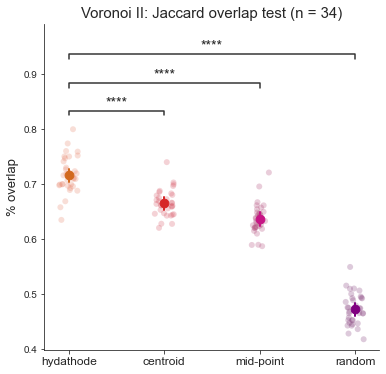

In [49]:
order = ['hydathode', 'centroid', 'mid-point', 'random']
colors = ['chocolate','tab:red', 'mediumvioletred', 'purple']
# colors = ['C1', 'C3', 'C6', 'C4']
sns.set_style("white")

fig, ax = plt.subplots(figsize = (6,6))

sns.stripplot (x = 'type', y = 'error', data = melted_J_mean_df, order = order, 
               palette = "flare", alpha = .25, size = 6, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_J_mean_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 14)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(J_results)['mean']['Intercept'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[centroid]'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[mid-point]'],
           az.summary(J_results)['mean']['Intercept'] + az.summary(J_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 2)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 75, zorder = 2)

    
ax.set_title('Voronoi II: Jaccard overlap test (n = 34)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 12)
ax.set_xlabel(None)
ax.set_ylabel('% overlap', fontsize = 13)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()


-------

### Step 3: voronoi center prediction (Voronoi III)

In [37]:
import center_predict

In [38]:
predict_err_arr = np.zeros([34,4])

In [39]:
def center_error_gcc(sample):

    print(f'Predict center for {sample}  \n')

    G = graph_create.graph_creation(sample, dot_folder, vein_folder)

    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)
    G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
    s_list, b_list, g_list, g_nodes_index = center_predict.slope_intercept_gcc(G, G_dual, shared_edges_mat)
    predicted_centers = center_predict.solve_lin_system_gcc(s_list, b_list, g_list)
    
    cent_list = [cent_in_faces[g_nodes_index[node]] for node in g_list]
    mid_list = [mid_in_faces[g_nodes_index[node]] for node in g_list ]
    rand_list = [rand_in_faces[g_nodes_index[node]] for node in g_list ]

    # errors:
    mean_dist = center_predict.mean_err(predicted_centers, g_list)
    cent_dist = center_predict.mean_err(predicted_centers, cent_list)
    mid_dist = center_predict.mean_err(predicted_centers, mid_list)
    rand_dist = center_predict.mean_err(predicted_centers, rand_list)

    print(f'Center prediction done. \n')

    return mean_dist, cent_dist, mid_dist, rand_dist

In [40]:
for i, sample in enumerate(sample_list):
    
    predict_err_arr[i] = center_error_gcc(sample)

Predict center for N1-1  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-2  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-3  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-4  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: mer

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-1  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-2  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-4  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N2-4  

Creatin

In [41]:
predict_err_df = pd.DataFrame(predict_err_arr, index = sample_list, columns = ['hydathode','centroid','mid-point','random'])

We'll only solve the linear system that is over-overdetermined, i.e., that has unique solutions.

In [43]:
def size_M(sample):

    print(f'Predict center for {sample}  \n')

    G = graph_create.graph_creation(sample, dot_folder, vein_folder)

    adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
    rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
    cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)
    G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
    s_list, b_list, g_list, g_nodes_index = center_predict.slope_intercept_gcc(G, G_dual, shared_edges_mat)

    print(f'Center prediction done. \n')

    return len(s_list), len(g_list)

In [44]:
size_df = np.zeros([34,2]) 

for i, sample in enumerate(sample_list):
    size_df[i] = size_M(sample)

Predict center for N1-1  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-2  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-3  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N1-4  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: mer

/Users/xinzheng/Desktop/Desktop/VeinTessellation/pilea_voronoi_test/voronoi_local.py:20: RuntimeWarning: divide by zero encountered in long_scalars
  s = (p1[1] - p2[1])/(p1[0] - p2[0])


- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-1  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-2  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N6-4  

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.

Center prediction done. 

Predict center for N2-4  

Creatin

In [45]:
size_df[:, 0] > size_df[:, 1]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [46]:
# we only want num equations > num variables.
predict_err_df = predict_err_df.drop(index = 'N1-3') 

In [62]:
samples.index = samples[0]

In [63]:
samples_gcc = samples.drop(index = 'N1-3')

In [64]:
predict_err_df['plant'] = samples_gcc[1].tolist()
predict_err_df['sample'] = predict_err_df.index

melted_predict_err_df = predict_err_df.melt(id_vars= ['sample', 'plant'] , var_name='type', value_name= 'error')
melted_predict_err_df["type"]  = pd.Categorical(melted_predict_err_df["type"].tolist(), 
                   categories = ['hydathode','centroid','mid-point','random'], ordered=True)

In [65]:
pred_model= bmb.Model("error ~ type + (1|plant)", melted_predict_err_df, dropna=True, categorical = "type")
pred_results =pred_model.fit(chains=5, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, type, 1|plant_sigma, 1|plant_offset, error_sigma]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 47 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5819, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6205, but should be close to 0.8. Try to increase the number of tuning steps.


In [66]:
pred_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [67]:
az.summary(pred_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,219.960,27.644,169.695,275.811,0.571,0.404,2356.0,2055.0,1.0
type[centroid],52.401,32.821,-8.985,112.877,0.523,0.370,3940.0,4518.0,1.0
type[mid-point],62.996,32.253,2.782,122.973,0.476,0.337,4585.0,5233.0,1.0
type[random],157.344,32.375,93.837,215.482,0.500,0.354,4203.0,4911.0,1.0
1|plant_sigma,32.258,25.913,0.009,76.287,0.793,0.712,1797.0,1411.0,1.0
error_sigma,131.185,8.356,116.223,147.126,0.115,0.081,5090.0,4950.0,1.0
1|plant[1],4.972,23.829,-41.431,52.239,0.475,0.387,2947.0,2729.0,1.0
1|plant[2],9.645,24.177,-35.538,59.668,0.447,0.364,3271.0,2928.0,1.0
1|plant[3],-14.321,25.578,-68.793,28.580,0.526,0.522,2987.0,2786.0,1.0
1|plant[4],-5.102,24.243,-55.424,40.483,0.511,0.446,2966.0,2306.0,1.0


In [68]:
slopes = pred_results.posterior.type.values
intercept = pred_results.posterior.Intercept.values
intercept = intercept.reshape((5,2000,1))

In [69]:
pvalues = [(slopes[:,:,0] <= 0).sum()/10000, (slopes[:,:,1] <= 0).sum()/10000, (slopes[:,:,2] <= 0).sum()/10000]
pairs = [('hydathode', 'centroid'), ('hydathode', 'mid-point'), ('hydathode', 'random')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

hydathode v.s. centroid: Custom statistical test, P_val:5.510e-02
hydathode v.s. mid-point: Custom statistical test, P_val:2.640e-02
hydathode v.s. random: Custom statistical test, P_val:0.000e+00


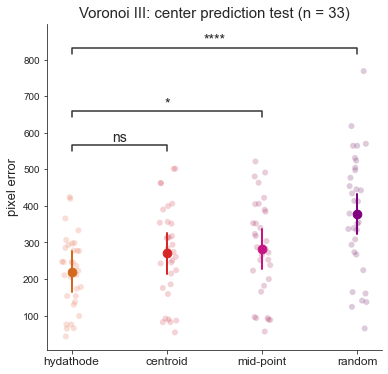

In [72]:
order = ['hydathode', 'centroid', 'mid-point', 'random']
colors = ['chocolate','tab:red', 'mediumvioletred', 'purple']
# colors = ['C1', 'C3', 'C6', 'C4']
sns.set_style("white")

fig, ax = plt.subplots(figsize = (6,6))

sns.stripplot (x = 'type', y = 'error', data = melted_predict_err_df, order = order, 
               palette = "flare", alpha = .25, size = 6, zorder=1,
               ax = ax)


ax, test_results = add_stat_annotation(ax, data = melted_predict_err_df, x= 'type', y= 'error', order = order,
                    box_pairs = pairs,
                    perform_stat_test = False,
                    pvalues = pvalues,
                    loc='inside',
                    fontsize = 14)

x = list(range(4))

y_lower = [np.percentile(a = intercept, q = 2.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 2.5).tolist()
y_higher = [np.percentile(a = intercept, q = 97.5)] + np.percentile(a = slopes + intercept, axis = [0,1], q = 97.5).tolist()
y = [az.summary(pred_results)['mean']['Intercept'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[centroid]'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[mid-point]'],
           az.summary(pred_results)['mean']['Intercept'] + az.summary(pred_results)['mean']['type[random]']]
for i in range(4):
    ax.plot([x[i], x[i]], [y_lower[i], y_higher[i]],  c = colors[i], lw = 2)
for i in range(4):
    ax.scatter(x[i], y[i],  c = colors[i], s = 75, zorder = 2)

    
ax.set_title('Voronoi III: center prediction test (n = 33)', fontsize = 15)
ax.set_xticklabels(['hydathode', 'centroid', 'mid-point', 'random'], fontsize = 12)
ax.set_xlabel(None)
ax.set_ylabel('pixel error', fontsize = 13)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()
